

---

# Image Segmentation

---

## 1. DATASET
### Download the dataset (images and the corresponding segmentation masks)

In [5]:
# images
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
# corresponding segmentation masks
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [9]:
# uncompressing our dataset
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

### Let’s prepare the list of input file paths, as well as the list of the corresponding mask file paths:

In [10]:
import os

In [11]:
input_dir = "images/"
target_dir = "annotations/trimaps/"

In [12]:
input_img_paths = sorted([os.path.join(input_dir, fname) 
                          for fname in os.listdir(input_dir) 
                          if fname.endswith(".jpg")])

In [13]:
target_paths = sorted([os.path.join(target_dir, fname) 
                       for fname in os.listdir(target_dir) 
                       if fname.endswith(".png") and not fname.startswith(".")])

### Sample image

In [14]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

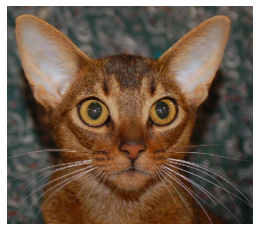

In [16]:
# Display input image number 55.
plt.axis("off")
plt.imshow(load_img(input_img_paths[55]))

In [17]:
# def display_target(target_array):
#     normalized_array = (target_array.astype("uint8") - 1) * 127
#     plt.axis("off")
#     plt.imshow(normalized_array[:, :, 0])

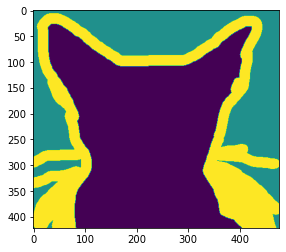

In [18]:
# And here is its corresponding target
img = img_to_array(load_img(target_paths[55], color_mode="grayscale"))
# display_target(img)
plt.imshow(img)

### Load our inputs and targets into two NumPy arrays, and let’s split the arrays into a training and a validation set

In [21]:
import numpy as np
import random

In [22]:
# We resize everything to 200 × 200
img_size = (200, 200)

# Total number of samples in the data
num_imgs = len(input_img_paths)

In [23]:
# Shuffle the file paths (they were originally sorted by breed).
# We use the same seed (42) in both statements to
# ensure that the input paths and target paths stay in the same order.

random.Random(42).shuffle(input_img_paths)
random.Random(42).shuffle(target_paths)

In [24]:
def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

In [25]:
def path_to_target(path):
    img = img_to_array(
    load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

In [26]:
# Load all images in the input_imgs float32 array and their masks in the
# targets uint8 array (same order). The inputs have three channels (RBG values)
# and the targets have a single channel (which contains integer labels).

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

In [27]:
# Reserve 1000 samples for validation.

num_val_samples = 1000

train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

---
## 2. MODEL
### Defining the model

In [28]:
from tensorflow import keras
from tensorflow.keras import layers

In [29]:

img_size = (200, 200)
num_classes = 3

inputs = keras.Input(shape = img_size + (3,))

x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
model = keras.Model(inputs, outputs)


In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

In [31]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

In [32]:
callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
    save_best_only=True)
]

#### it took me `Wall time: 1h 48min 27s` on GPUs to train this model

In [ ]:
%%time
history = model.fit(train_input_imgs, train_targets,
    epochs=50,
    callbacks=callbacks,
    batch_size=64,
    validation_data=(val_input_imgs, val_targets))

### Using the Estimated Model

In [33]:
model = keras.models.load_model("image_segmentation.keras")

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

### Сhecking the model on images

In [35]:
from tensorflow.keras.utils import array_to_img
from tensorflow.keras.preprocessing import image

In [46]:
def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

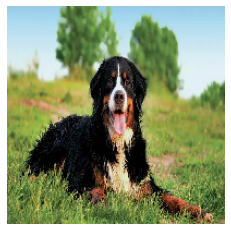

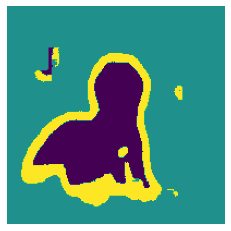

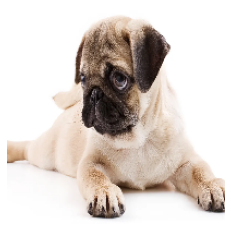

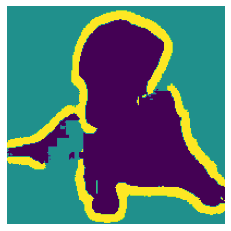

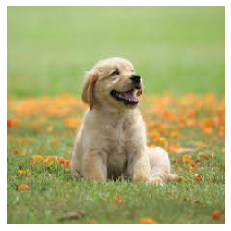

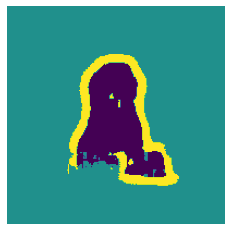

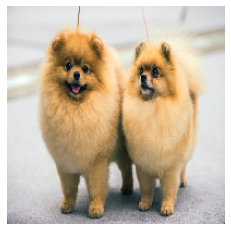

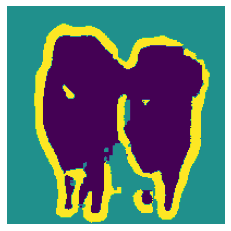

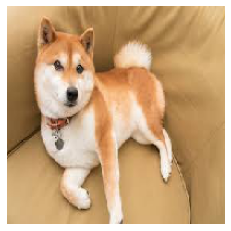

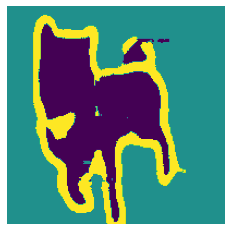

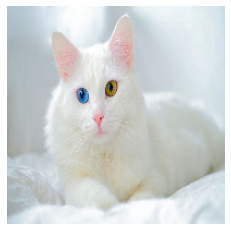

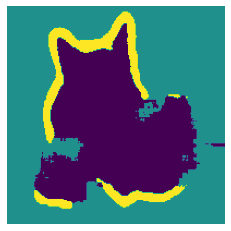

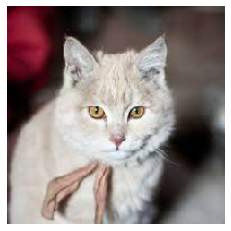

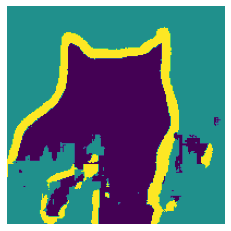

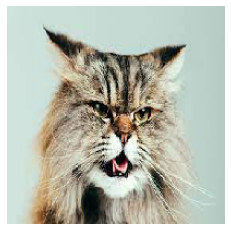

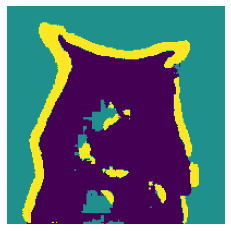

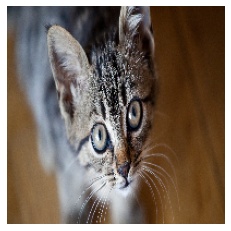

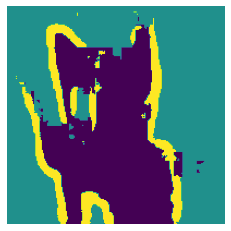

In [55]:
for i in range(0, 9):
    img_path = f"./sest_pets/{i}.jpg"
    img = image.load_img(img_path, target_size = (200, 200))
    img_array = image.img_to_array(img)
    test_image = img_array
    plt.axis("off")
    plt.imshow(array_to_img(test_image))
    plt.show();
    mask = model.predict(np.expand_dims(test_image, 0))[0]
    display_mask(mask)
    plt.show();

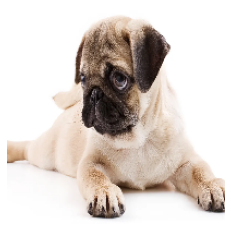

In [49]:
test_image = img_array
plt.axis("off")
plt.imshow(array_to_img(test_image))
mask = model.predict(np.expand_dims(test_image, 0))[0]

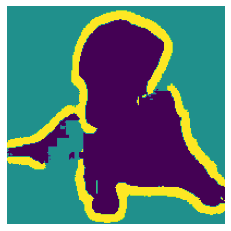

In [39]:
display_mask(mask)